# 1. RIR mixed Simulation dataset에 대해 AEC -> ELRE 계산

In [1]:
import glob
import os
import numpy as np
import soundfile as sf
import AEC_speex as aec
from tqdm import tqdm
import re

In [2]:
save_path = '/home/nas3/project/2023_LG_HA/data/240911_AEC_simulation_dataset/'
save_folder =['clean_speech/', 'speech_rir/', 'echo_rir/', 'clean_echo/', 'mixture/']

file_list = []
for folder in save_folder:
    file_list.append(glob.glob(save_path + folder + '*.wav'))

# Check file length
len(file_list), len(file_list[0]), len(file_list[1]), len(file_list[2]), len(file_list[3]), len(file_list[4])

(5, 225, 225, 225, 225, 225)

### 1.1. Define AEC

In [3]:
# Import data
ERLE_arr = []
SNR_arr = []

length = len(file_list[0])
s_folder = ['processed_output/', 'estimated_echo/']
os.makedirs(save_path + f'{s_folder[0]}', exist_ok=True)
os.makedirs(save_path + f'{s_folder[1]}', exist_ok=True)

for i in range(length):
    match = re.search(r'_SNR_(-?\d+\.\d+)', file_list[4][i])
    if match:
        snr_value = match.group(1)
        SNR_arr.append(snr_value)
        
temp = 10        

for idx in tqdm(range(length)):
    s, _ = sf.read(file_list[0][idx])
    s_rir, _ = sf.read(file_list[1][idx])
    e_rir, _ = sf.read(file_list[2][idx])
    e, _ = sf.read(file_list[3][idx])
    x, sr = sf.read(file_list[4][idx])

    # load metric
    aec_speech, aec_echo = aec.run_AEC(e, x, sr, processor=aec.MDF,
                                # output_filename="AEC_RIRMIX"
                                )
    # Save output
    # sf.write(save_path + s_folder[0] + f'{idx}_SNR_{SNR_arr[idx]}_processed_output.wav', aec_speech, sr)
    # sf.write(save_path + s_folder[1] + f'{idx}_SNR_{SNR_arr[idx]}_estimated_echo.wav',   aec_echo,   sr)

    erle = aec.calculate_erle(e_rir, aec_echo, dropout=0.2,tag='simulation', opt_print=False)
    if (temp > erle): 
        temp = erle
        print(idx, file_list[0][idx])
    ERLE_arr.append(erle)


 76%|███████▋  | 172/225 [07:03<02:02,  2.32s/it]

171 /home/nas3/project/2023_LG_HA/data/240911_AEC_simulation_dataset/clean_speech/171_s.wav


100%|██████████| 225/225 [09:16<00:00,  2.47s/it]


In [4]:
# 최소값 정보
temp

5.080720764117961

### 1.2. Plot Result of Simulation dataset

Text(0.5, 1.0, 'ERLE (dB): 15.650')

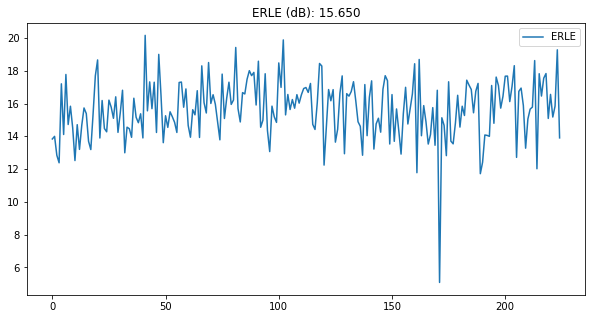

In [5]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
plt.plot(ERLE_arr, label='ERLE')
plt.legend()
plt.title(f"ERLE (dB): {np.mean(ERLE_arr):.3f}")
         

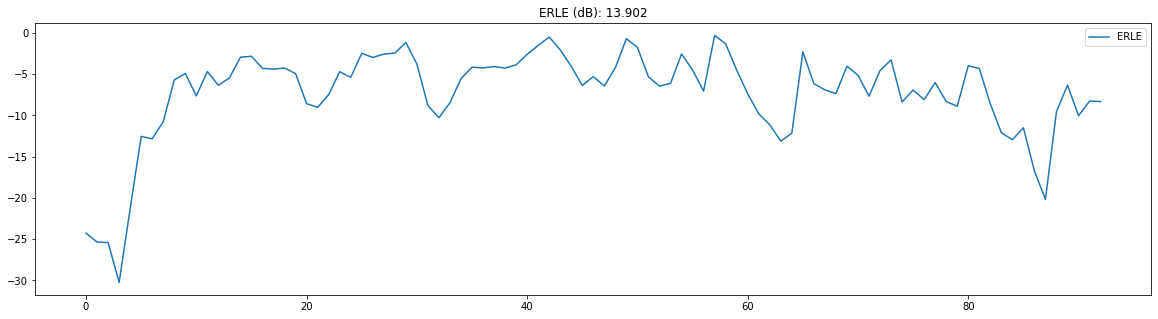

In [10]:
# ERLE graph
import matplotlib.pyplot as plt

win_erle_1 = aec.windowed_calculate_erle(e_rir, aec_echo, tag='simulation')

plt.figure(figsize=(20, 5))
plt.plot(win_erle_1, label="ERLE")
plt.legend()

# spacing = int(len(x)/(1024*5))  # 간격
# for xc in range(0, len(win_erle_1), spacing):
#     plt.axvline(x=xc, color='gray', linestyle='--', alpha=0.7)
    
plt.title(f"ERLE (dB): {erle:.3f}")
plt.show()

### 1.3. See sample

In [7]:
import IPython.display as ipd
ipd.Audio(file_list[4][idx], rate=16000)

In [8]:
ipd.Audio(aec_echo, rate=16000)

- ERLE of One sample

In [17]:
file_list[2][171], aec_echo

('/home/nas3/project/2023_LG_HA/data/240911_AEC_simulation_dataset/echo_rir/171_SNR_-8.52_e_rir.wav',
 array([1.53808594e-05, 2.91093750e-05, 4.61017450e-05, ...,
        7.62849148e-02, 5.81744116e-02, 3.71545447e-02]))

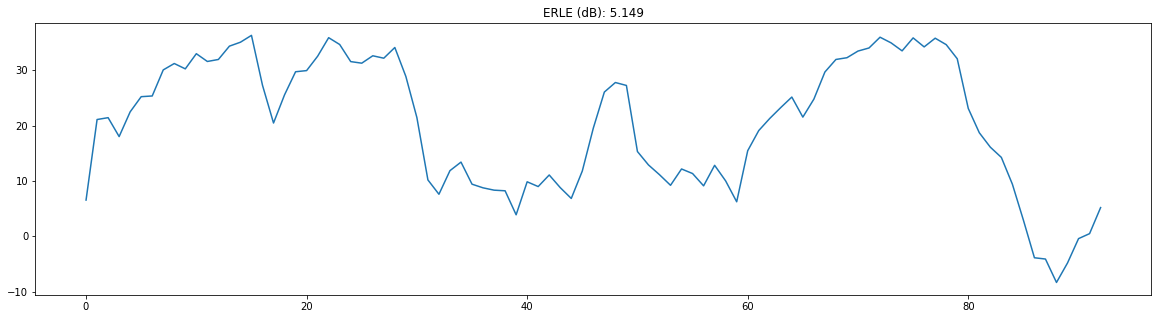

In [19]:
import matplotlib.pyplot as plt
e, _ = sf.read(file_list[3][171])
s, _ = sf.read(file_list[4][171])
aec_speech, aec_echo = aec.run_AEC(e, s, 16000, processor=aec.MDF,
                        # output_filename="AEC_RIRMIX"
                            )
    
# ERLE graph
e1 = aec.calculate_erle(sf.read(file_list[2][171])[0], aec_echo, dropout=0,tag='simulation', opt_print=False)
# el = aec.windowed_calculate_erle(sf.read(file_list[2][171])[0], aec_echo, tag='simulation', window_size=len(e))

win_erle_1 = aec.windowed_calculate_erle(sf.read(file_list[2][171])[0], aec_echo, tag='simulation')

plt.figure(figsize=(20, 5))
plt.plot(win_erle_1)

plt.title(f"ERLE (dB): {e1:.3f}")
plt.show()


# 2. Real dataset에 대한 ERLE 측정 with Post-processing

### 2.1. Case of Speech

In [20]:
save_path = '/home/nas3/project/2023_LG_HA/data/0611_forAEC/'
save_folder =['estimated/', 'original/']

s_list = glob.glob(save_path + save_folder[1] + '*xu.wav')
aec_echo_list = glob.glob(save_path + save_folder[0] + '*e.wav')

ERLE_arr = []

for idx, item in tqdm(enumerate(s_list)):
    xu, _ = sf.read(s_list[idx])
    x = xu[:, 0]
    aec_echo, _ = sf.read(aec_echo_list[idx])

    erle = aec.calculate_erle(x, aec_echo, dropout=0.2, tag='real', opt_print=False)
    ERLE_arr.append(erle)


30it [00:00, 119.25it/s]


In [21]:
aec_echo_list[15], ERLE_arr[15]

('/home/nas3/project/2023_LG_HA/data/0611_forAEC/estimated/jwk_02_00_e.wav',
 13.868261854263489)

- Plot ERLE of Real & Post-processing

Text(0.5, 1.0, 'ERLE (dB): 7.973')

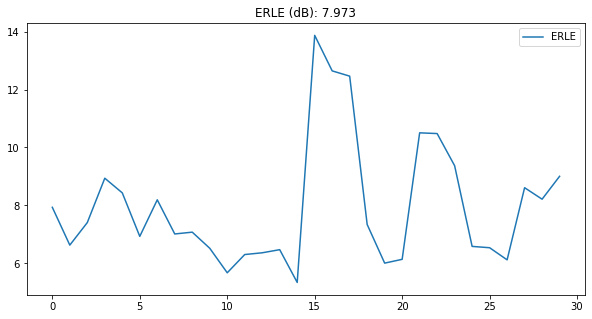

In [22]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
plt.plot(ERLE_arr, label='ERLE')
plt.legend()
plt.title(f"ERLE (dB): {np.mean(ERLE_arr):.3f}")

In [23]:
path ='/home/nas3/project/2023_LG_HA/20240719_meeting/AEC/AEC_crop/'
u_path ='u'
y_path ='y'
d_path = 'd'
y_post_path = 'y_post'

### 2.2. Case of non-Speech

In [24]:
# Define the path
save_path = '/home/nas3/project/2023_LG_HA/20240719_meeting/AEC/AEC_crop/'
save_folder =['d/', 'u/', 'y/', 'y_post/']

file_list = []
for folder in save_folder:
    file_list.append(glob.glob(save_path + folder + '*.wav'))

# Check the number of files
len(file_list[0]), len(file_list[1]), len(file_list[2]), len(file_list[3])

ERLE_arr = []

# Calculate ERLE
for idx in tqdm(range(len(file_list[0]))):
    d, _ = sf.read(file_list[0][idx])
    u, _ = sf.read(file_list[1][idx])
    y, _ = sf.read(file_list[2][idx])
    y_post, _ = sf.read(file_list[3][idx])
    
    length = min(len(d), len(u), len(y), len(y_post))
    d = d[:length]
    u = u[:length]
    y = y[:length]
    y_post = y_post[:length]

    erle = aec.calculate_erle(d, d-y_post, dropout=0.2,tag='real', opt_print=False)
    ERLE_arr.append(erle)


  0%|          | 0/54 [00:00<?, ?it/s]

100%|██████████| 54/54 [00:00<00:00, 130.71it/s]


Text(0.5, 1.0, 'ERLE (dB): 17.895')

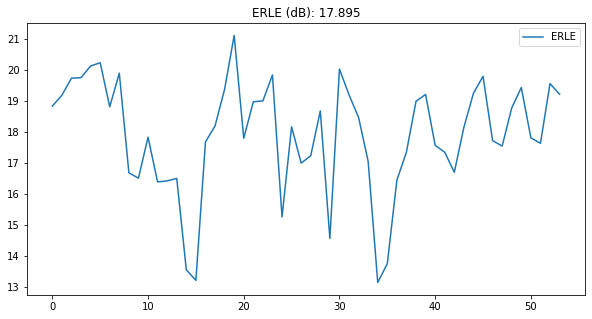

In [25]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
plt.plot(ERLE_arr, label='ERLE')
plt.legend()
plt.title(f"ERLE (dB): {np.mean(ERLE_arr):.3f}")
         

# 3. Real dataset에 대한 ERLE 측정 with no post-processing

In [26]:
import glob
import os
import numpy as np
import soundfile as sf
import AEC_speex as aec
from tqdm import tqdm
import re

In [27]:
dir_path = '/home/nas3/project/2023_LG_HA/data/0611_forAEC/'
folder_name =['original/', 'estimated_non_PP/']

file_list = []
for folder in folder_name:
    file_list.append(glob.glob(dir_path + folder + '*.wav'))

len(file_list), len(file_list[0]), len(file_list[1])
file_length = len(file_list[0])

In [28]:
# Import data
ERLE_arr = []
e_filename = []
s_filename = []

# s_folder = ['processed_output/', 'estimated_echo/']

for i in range(file_length):
    match = re.search(r'[a-z]+_\d+_\d+_', file_list[0][i])
    if match:
        fn = match.group()
        e_filename.append(fn + 'e.wav')
        s_filename.append(fn + 's.wav')

In [29]:
for idx in tqdm(range(file_length)):
    xu, sr = sf.read(file_list[0][idx])
    x = xu[:, 0]
    e = xu[:, 1]

    # load metric
    aec_speech, aec_echo = aec.run_AEC(e, x, sr, processor=aec.MDF,
                                # output_filename="AEC_RIRMIX"
                                )
    
    # sf.write(dir_path + folder_name[1] + s_filename[idx], aec_speech, sr)
    # sf.write(dir_path + folder_name[1] + e_filename[idx], aec_echo,   sr)

    erle = aec.calculate_erle(x, aec_echo, dropout=0.2, tag='real', opt_print=False)
    ERLE_arr.append(erle)
    

  7%|▋         | 2/30 [00:18<04:16,  9.17s/it]

- Plot results

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
plt.plot(ERLE_arr, label='ERLE')
plt.legend()
plt.title(f"ERLE (dB): {np.mean(ERLE_arr):.3f}")